Improvements to the Phoenix model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
import prepare_phoenix

#{'Teff':data['Teff__0'], 'logg': logg, 'FeH': FeH, 'aM': aM}
Params from B+M 17: https://ui.adsabs.harvard.edu/abs/2017ApJ...845..110B/abstract


In [16]:
teff = 2650*u.K
distance = 12.49*u.pc #~consistant with gaia
mass = 0.080*u.M_sun
radius = 0.121*u.R_sun
FeH = 0.04
g = ((const.G.to(u.cm**3/(u.g*u.s**2))*mass.to(u.g))/(radius.to(u.cm)**2))
print(g)
logg = np.log10(g.value)
print(logg)

149825.89257967248 cm / s2
5.175586873662176


In [20]:
star_params =  {'Teff':teff.value, 'logg': logg, 'FeH': FeH, 'aM': 0}

In [22]:
wavefile= 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
savepath = ''
pw, pf =prepare_phoenix.make_phoenix_spectrum('trappist-1',wavefile, '.', '.', star_params, save_ecsv=True, plot=False)

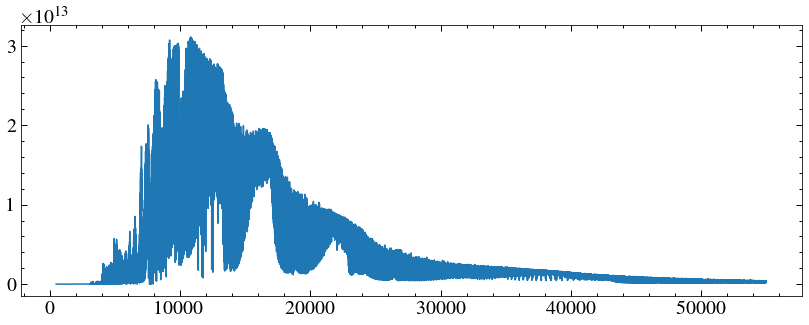

In [23]:
plt.plot(pw, pf)

Ok let's scale with distance and wavelength rather than fitting. Current = 1.59e-28 

In [34]:
scale = (radius.to(u.cm)/distance.to(u.cm))**2*1e-8 #correctin to A
print(scale)

4.770773301498139e-28


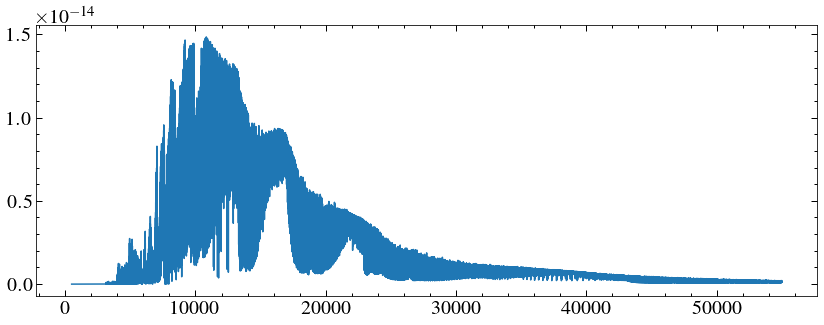

In [35]:
plt.plot(pw, pf*scale)

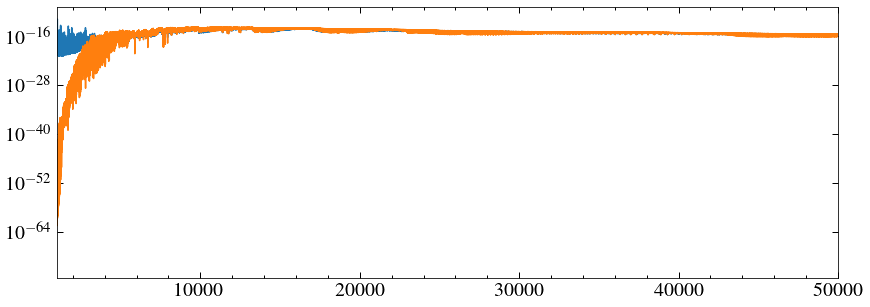

In [42]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
mods = os.listdir(mpath)
for mod in mods[0:1]:
    mw, mf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    plt.plot(mw, mf*scale/1e-8)
plt.plot(pw,pf*scale)
plt.xlim(1000, 50000)
plt.yscale('log')

In [32]:
hdul = fits.open('lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

In [33]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               2500.0 / [K] effective temperature                      
PHXLOGG =                  5.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

Flux is in per cm not per A!!!!!!! Fixed above. How does that compare to STIS?

In [43]:
stis_opt = 'odlm41010_sx1.fits'
data = fits.getdata('../combined/'+stis_opt,1)[0]
wo = data['WAVELENGTH']#[dt['DQ']==0]
fo = data['FLUX']#[dt['DQ']==0]
mask = (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo = wo[mask], fo[mask]

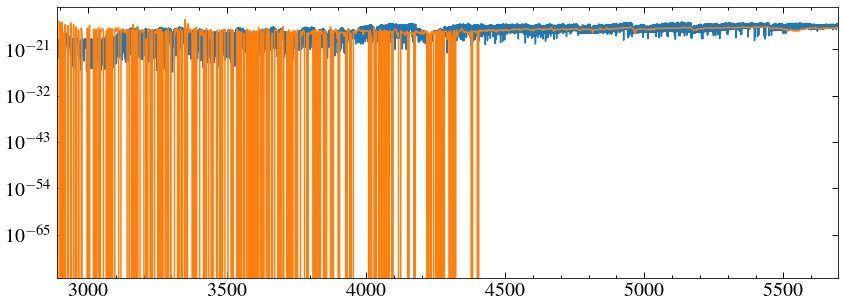

In [49]:
plt.plot(pw, pf*scale)
plt.plot(wo, fo)
plt.xlim(wo[0], wo[-1])
#plt.ylim(-0.1e-15, 0.3e-14)
plt.yscale('log')

Reasonable, I think this is the better way forward given the scaling is almost included by the choice of model. What about the ir data?